NLP Classification project to predict the correct Subreddit class - Cricket Vs Soccer

- By: [Kathirvel Kumararaja]()

## Problem Statement

ESPN has hired DevJee Inc. to address a data collection issue in their market research team. The market research team is responsible for analyzing  and compiling online fan participation in two major sports viz. Cricket and Soccer. The feeds are coming from Subreddit blogs.
The issue we are facing is the team of interns that collects the data doesn't have much idea of these sports and mixes the blogs before passing it to the research team. We are tasked to come out with a solution that correctly identifies the type of blogs.
  - We will be using Using Pushshift's API to collect the data from subreddits of Cricket and Soccer.  
  - We will use NLP to train a classifier on which subreddit a given post came from. 
  - We will be evaluating our model based on Testing Accuracy Score 
  

![title](../images/Cric_Soccer.png)

## Executive Summary

To address the challenge of finding the correct reddit post, our first strategy is to finalize a good reddit source for comparing the two popular sports Soccer and Cricekt. While most of us think Soccer as the most popular sports, data told us a different story. Cricket is played around 50 countries with 2.5 billion fans while football is played in over 200 countries with 3.5 billion fans. In other words per country there are 50 million cricket fans compared to 17.5 million football fans. It was a challenge to get a correct key word for the amount of data that we needed. We started with specific clubs of these sports and generalized to get enough data. 

Another challenge we were having was getting enough data (our target was close to 2000 records in each subreddit). I had to change the day window to attain this objective. Once I adjusted the day window to 15 and appropriate fequency I was able to collect enough data for training our models.

After extracting the blog post data next decision we had to make was what column or columns needs to be my X. We were inclined to use 'Title' and 'Self text' consdering the relevance of the contents. But after reviewing the shape of data and Null values we have decided to use only 'Title' as 'Self Text' was not adding much value in training my model.  

EDA helped me set up a preprocessing plan for our model. For preprocessing, I had created a fucntion that used regex, lemmatizatizer which removed punctuation and stopwords. For modeling, I used  TFIDF and Count vetorizers. They brought context of word choices into play, which will give us a better understanding of the group of words used in a reddit blog post about the sports we are analyzing.
 
Machines had no problem understanding the blog posts, after using vectorizers.

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import time
import requests

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix

import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from nltk.stem import PorterStemmer
import datetime as dt
import time

from sklearn.metrics import roc_auc_score

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import regex as re
import nltk
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings("ignore") 

#importing GaussianNB

from sklearn.naive_bayes import GaussianNB
from sklearn.base import TransformerMixin # this allows us to create a custom transformer

%matplotlib inline

## Data Collection

In [2]:
#Read the data for Cricket
df_cricket = pd.read_csv("../data/cricket.csv",index_col=0)

In [3]:
#Read the data for Soccer
df_soccer = pd.read_csv("../data/soccer.csv", index_col=0)

In [4]:
df_cricket.head()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,How Far Away Is The Standard Of Women's Cricke...,"Hey, guys, I was wondering how far away do you...",Cricket,1578939100,Equivalent-Winner,10,1,True,2020-01-13
6,Nitro Strength Muscle supplement,[removed],Cricket,1578946035,Jonson15555,0,1,True,2020-01-13
13,"In International Test Cricket, What Was The Be...","Hey, guys IMO Brendon McCullum's 302 vs India ...",Cricket,1578950019,Equivalent-Winner,10,1,True,2020-01-13
15,Why Is Cricket Not Played At The Olympics?,I believe there was a cricket tournament playe...,Cricket,1578952373,Equivalent-Winner,14,1,True,2020-01-13
17,Who is the Cricketer of the Decade?,1. **Virat Kohli**\n2. **Ab Devillers**\n3. **...,Cricket,1578953445,Mudasariqbal,7,1,True,2020-01-13


In [5]:
df_cricket.shape

(2458, 9)

In [6]:
df_soccer.head()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
6,Can someone explain to me how to U23 system wo...,I just watched YouTube highlight video from Ev...,soccer,1579370480,coco4shade,33,1,True,2020-01-18
8,hi,[removed],soccer,1579370636,CecileSmith11,0,1,True,2020-01-18
14,hi,[removed],soccer,1579371306,CecileSmith11,0,1,True,2020-01-18
22,hi,[removed],soccer,1579371939,CecileSmith11,0,1,True,2020-01-18
23,In most countries the word for goal has the sa...,[removed],soccer,1579371966,barbapapi_,0,1,True,2020-01-18


In [7]:
df_soccer.shape

(2059, 9)

In [8]:
# combining both the dataframes using concatenate
combined_df = pd.concat(objs = [df_cricket, df_soccer],
                    axis = 0)

In [9]:
combined_df.shape

(4517, 9)

## Data Cleaning & EDA

In [10]:
#checking for Null values in the dataframe
#combined_df[combined_df.isnull().any(axis=1)]
combined_df.isnull().sum()

title            0
selftext        70
subreddit        0
created_utc      0
author           0
num_comments     0
score            0
is_self          0
timestamp        0
dtype: int64

In [11]:
#checking for duplicates
combined_df.duplicated().sum()

0

In [12]:
#Checking that data in our target column 'cAGR'
combined_df['subreddit'].describe()

count        4517
unique          2
top       Cricket
freq         2458
Name: subreddit, dtype: object

In [13]:
#converting the categorical columns 'Cricket' and 'soccer' to 1 and 0
combined_df['subreddit'] = combined_df['subreddit'].map({'Cricket': 1, 'soccer': 0})

In [14]:
combined_df['subreddit'].describe()

count    4517.000000
mean        0.544166
std         0.498101
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: subreddit, dtype: float64

In [15]:
combined_df['title'].describe()

count                             4517
unique                            4319
top       공식 스포츠토토 — 안전놀이터 추천 by happy
freq                                27
Name: title, dtype: object

This needs to be cleaned up.

In [16]:
combined_df['selftext'] = combined_df['selftext'].str.replace('removed','')
combined_df['selftext'] = combined_df['selftext'].str.replace('[','')
combined_df['selftext'] = combined_df['selftext'].str.replace(']','')

Tokenize- Split up title data object into chunks to recognize patterns

Lemmatize- Form of shortening words so we can combine words. Reduce the base/dictionary form of the word

Stemming- Return base form of the word. Tends to be cruder than lemmatizing

Lower- Make into lower case.

In [17]:
#nltk.download('punkt')

In [18]:
##instantiate porter stemmer 
##list comp for each value
##.join to join list
ps = PorterStemmer()

combined_df['tokenized_title'] = [nltk.word_tokenize(doc) for doc in combined_df['title']]

combined_df['stemmed_title'] = [[ps.stem(word) for word in row] for row in combined_df['tokenized_title']]

combined_df['lower_title'] = [[word.lower() for word in row] for row in combined_df['stemmed_title']]

combined_df['newtext_title'] = [" ".join(row) for row in combined_df['lower_title']]

### Understaning the day wise trend of posts.

In [19]:
# using dt.date.fromtimestamp
dt.date.fromtimestamp(1579572662) # converts epoch time to datetime

datetime.date(2020, 1, 20)

In [20]:
# Creating `timestamp` column using `created_utc` column
combined_df["timestamp"] = combined_df["created_utc"].map(dt.date.fromtimestamp)
combined_df["timestamp"].head()

0     2020-01-13
6     2020-01-13
13    2020-01-13
15    2020-01-13
17    2020-01-13
Name: timestamp, dtype: object

In [21]:
#making the days into an array of numbers
combined_df['timestamp'] = pd.to_datetime(combined_df.timestamp) 
combined_df['day'] = combined_df['timestamp'].dt.dayofweek
combined_df['day'].unique()

array([0, 1, 2, 3, 4, 6, 5])

In [22]:
# assigning key value to the weekdays from Monday thru Friday using .map method.
combined_df['weekday'] = combined_df['day'].map({0: 'Monday', 
                               1: 'Tuesday',
                               2: 'Wednsday',
                               3: 'Thursday',
                               4: 'Friday',
                               5: 'Saturday',
                               6: 'Sunday'})
combined_df['weekday'].unique()

array(['Monday', 'Tuesday', 'Wednsday', 'Thursday', 'Friday', 'Sunday',
       'Saturday'], dtype=object)

In [23]:
#finding the daywise totals of the comments.
combined_df['weekday'].value_counts()

Saturday    783
Sunday      739
Tuesday     707
Wednsday    694
Monday      567
Thursday    518
Friday      509
Name: weekday, dtype: int64

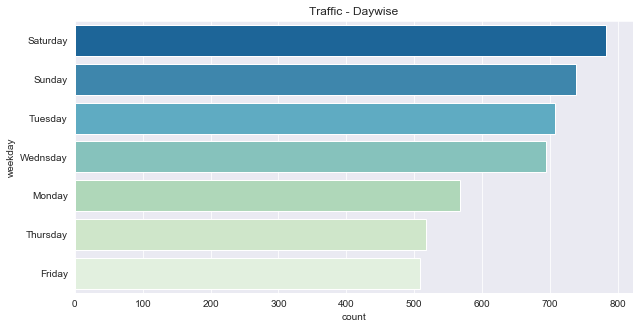

In [24]:
#Plot of posts traffic - Day wise
plt.figure(figsize=(10,5))
sns.set_style('darkgrid')
plt.title('Traffic - Daywise')
sns.countplot(data=combined_df,
              y='weekday', 
              order = combined_df['weekday'].value_counts().index,
              palette="GnBu_r");

### Most commented posts

In [25]:
# finding the posts those have has more than 10000 
df1_comments = combined_df[(combined_df['subreddit'] == 1) & (combined_df['num_comments']> 10000)]
df1_comments

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp,tokenized_title,stemmed_title,lower_title,newtext_title,day,weekday
44,Match Thread: 1st ODI - India v Australia,1st ODI - India v Australia,1,1578982362,CricketMatchBot,14378,1,True,2020-01-14,"[Match, Thread, :, 1st, ODI, -, India, v, Aust...","[match, thread, :, 1st, odi, -, india, v, aust...","[match, thread, :, 1st, odi, -, india, v, aust...",match thread : 1st odi - india v australia,1,Tuesday
467,Match Thread: 2nd ODI - India v Australia,2nd ODI - India v Australia,1,1579241683,CricketMatchBot,15126,1,True,2020-01-17,"[Match, Thread, :, 2nd, ODI, -, India, v, Aust...","[match, thread, :, 2nd, odi, -, india, v, aust...","[match, thread, :, 2nd, odi, -, india, v, aust...",match thread : 2nd odi - india v australia,4,Friday
479,Match Thread: 3rd Test - Australia v New Zeala...,"###3rd Test, ICC World Test Championship at Sy...",1,1578001159,CricketMatchBot,14182,332,True,2020-01-02,"[Match, Thread, :, 3rd, Test, -, Australia, v,...","[match, thread, :, 3rd, test, -, australia, v,...","[match, thread, :, 3rd, test, -, australia, v,...",match thread : 3rd test - australia v new zeal...,3,Thursday
61,"Match Thread: 2nd Test - England v Australia, ...","2nd Test - England v Australia, Day 4",1,1566029688,CricketMatchBot,13182,310,True,2019-08-17,"[Match, Thread, :, 2nd, Test, -, England, v, A...","[match, thread, :, 2nd, test, -, england, v, a...","[match, thread, :, 2nd, test, -, england, v, a...",match thread : 2nd test - england v australia ...,5,Saturday
216,"Match Thread: 2nd Test - England v Australia, ...","2nd Test - England v Australia, Day 5",1,1566116021,CricketMatchBot,12662,346,True,2019-08-18,"[Match, Thread, :, 2nd, Test, -, England, v, A...","[match, thread, :, 2nd, test, -, england, v, a...","[match, thread, :, 2nd, test, -, england, v, a...",match thread : 2nd test - england v australia ...,6,Sunday
96,"Match Thread: 1st Test - England v Australia, ...","1st Test - England v Australia, Day 2",1,1564733461,CricketMatchBot,10263,413,True,2019-08-02,"[Match, Thread, :, 1st, Test, -, England, v, A...","[match, thread, :, 1st, test, -, england, v, a...","[match, thread, :, 1st, test, -, england, v, a...",match thread : 1st test - england v australia ...,4,Friday
370,"Match Thread: 1st Test - England v Australia, ...","1st Test - England v Australia, Day 4",1,1564906164,CricketMatchBot,13813,386,True,2019-08-04,"[Match, Thread, :, 1st, Test, -, England, v, A...","[match, thread, :, 1st, test, -, england, v, a...","[match, thread, :, 1st, test, -, england, v, a...",match thread : 1st test - england v australia ...,6,Sunday
182,Match Thread: 41st match - England v New Zealand,41st match - England v New Zealand,1,1562139302,CricketMatchBot,17470,586,True,2019-07-03,"[Match, Thread, :, 41st, match, -, England, v,...","[match, thread, :, 41st, match, -, england, v,...","[match, thread, :, 41st, match, -, england, v,...",match thread : 41st match - england v new zealand,2,Wednsday
359,Match Thread: 25th match - New Zealand v South...,25th match - New Zealand v South Africa,1,1560930016,CricketMatchBot,10575,505,True,2019-06-19,"[Match, Thread, :, 25th, match, -, New, Zealan...","[match, thread, :, 25th, match, -, new, zealan...","[match, thread, :, 25th, match, -, new, zealan...",match thread : 25th match - new zealand v sout...,2,Wednsday


### Finding the most frequently used words

In [26]:
# finding the most frequently used words
cvec = CountVectorizer( stop_words = 'english')
combined_df_cv = cvec.fit(combined_df['title'])

In [27]:
#Thanks to Varun / Ruchika for helping in this logic
combined_df_cv = pd.DataFrame(cvec.transform(combined_df['title']).todense(),columns=cvec.get_feature_names())
highest_cv = combined_df_cv.sum(axis=0)
combined_df_cvec = highest_cv.sort_values(ascending = False).head(10)
combined_df_cvec = pd.DataFrame(combined_df_cvec, columns = ['Count_Vectorizer(units)'])
combined_df_cvec

,Count_Vectorizer(units)
match,1276
thread,1105
vs,679
cricket,324
league,309
test,275
post,273
cup,261
2019,257
world,225


In [28]:
# creating the list of stop words
stopwords = nltk.corpus.stopwords.words('english')
newStopWords = list(combined_df_cvec.index) #popular words from post
stopwords.extend(newStopWords) # updating the standard stop words

In [29]:
stopwords1 = nltk.corpus.stopwords.words('english').append(['soccer', 'cricket'])

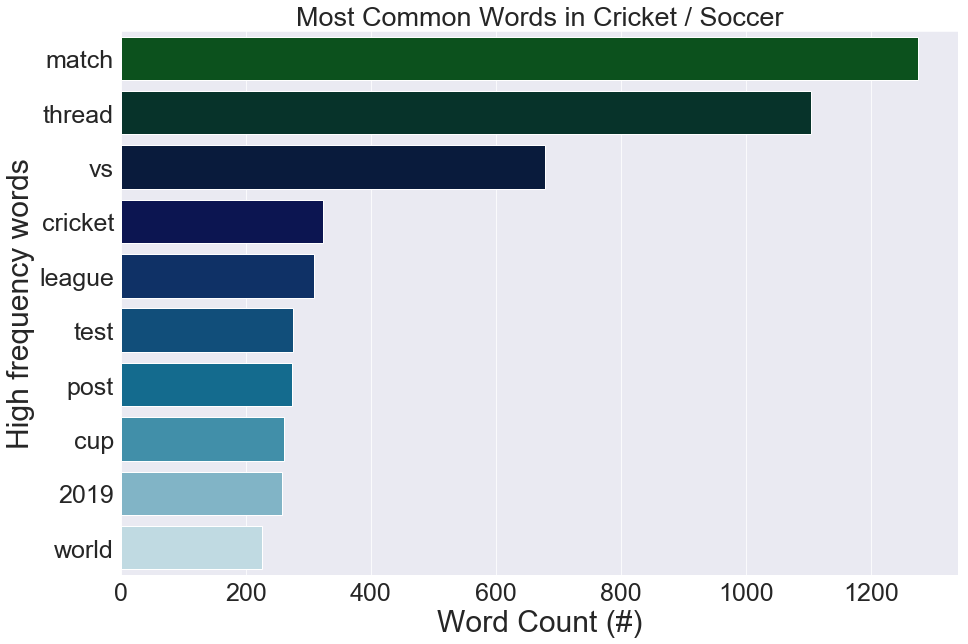

In [30]:
plt.figure(figsize=(15,10))
sns.barplot(data=combined_df_cvec,
            y=list(combined_df_cvec.index),
            x='Count_Vectorizer(units)',
            palette="ocean");
#Setting the title to size 30
plt.title ('Most Common Words in Cricket / Soccer',
           size=27);
plt.ylabel('High frequency words', size = 30);
plt.xlabel('Word Count (#)', size = 30);
#setting size of yticks and xticks to 25
plt.yticks(size = 25);
plt.xticks(size = 25);

## Preprocessing & Modeling

Run cross val score for all the models

In [31]:
# Train test split
X = combined_df['title']
y = combined_df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.3, stratify = y)

### Base line model

In [32]:
#calculating base line score. 
y.value_counts(normalize = True)

1    0.544166
0    0.455834
Name: subreddit, dtype: float64

 **Base Line score of our model is 0.54**

In [33]:
#with help from Ruchika on the logic
def pre_process(string):
    string = re.sub('[0-9]+', '', string) # using regex converting numbers to ''
    lemmatizer = WordNetLemmatizer() # lemmatizing the text
    lem_list = []
    strings = string.split()
    for word in strings:
        lem_string = lemmatizer.lemmatize(word) 
        lem_list.append(lem_string)
    lem_sentence = ' '.join(lem_list)
    return lem_sentence

### Logistics  - Count vec 

In [34]:
# From Mahdi's local lessons 
# using pipe function to 

pipe = Pipeline(steps = [('vectorizer', CountVectorizer(pre_process)), # first tuple is for first step: vectorizer
                         ('model', LogisticRegression(solver = 'liblinear'))
                         
                        ])    

# Construct Grid Parameters
hyperparams = {'vectorizer__ngram_range': [(1,1), (1,2)],
               'vectorizer__stop_words': [stopwords1, stopwords, None ],
               'vectorizer__max_features' : [100,500],# how to make sure all test cases
                                                        # use a single value that isn't built into
                                                        # the defaults (otw: stopwords left in)
               'model__penalty': ['l1', 'l2'], # for Ridge and Lasso
               'model__C': [3, 10, 1000]
                
              }

 # Perform Grid Search
gs = GridSearchCV(pipe, # pipeline object replaces what we usually had as empty model class
                 param_grid=hyperparams,
                 cv = 3,
                 scoring = 'accuracy')
results = gs.fit(X_train, y_train)

In [35]:
#running score with best params
gs_model = gs.best_estimator_
gs_model.score(X_train, y_train)

0.9186966149952547

In [36]:
# Get score
train_score = gs.best_score_
print('Best CV : {:.4f}'.format(train_score))

test_score = gs.score(X_train, y_train)
print('Best TRAIN set accuracy: {:.4f}'.format(test_score))

test_score = gs.score(X_test, y_test)
print('Best TEST set accuracy: {:.4f}'.format(test_score))

Best CV : 0.8538
Best TRAIN set accuracy: 0.9187
Best TEST set accuracy: 0.8709


**Interpretation of the model : The above Logistic Regression model with CountVectorizer has accuracy of 0.92 for my training set and has accuracy 0.87 for my testing set. This model outpeformed my baseline model score of 0.54**

###  Logistic - TFIDF

In [37]:
# From Mahdi's local lessons 

pipe = Pipeline(steps = [('vectorizer', TfidfVectorizer(pre_process)), # first tuple is for first step: vectorizer
                         ('model', LogisticRegression(solver = 'liblinear'))
                         
                        ])    

# Construct Grid Parameters
hyperparams = {'vectorizer__ngram_range': [(1,1), (1,2)],
               'vectorizer__stop_words': ['english', stopwords, None ],
               'vectorizer__max_features' : [100,500],# how to make sure all test cases
                                                        # use a single value that isn't built into
                                                        # the defaults (otw: stopwords left in)
               'model__penalty': ['l1', 'l2'], # for Ridge and Lasso
               'model__C': [3, 10, 1000]
                
              }

 # Perform Grid Search
gs_tfdf = GridSearchCV(pipe, # pipeline object replaces what we usually had as empty model class
                 param_grid=hyperparams,
                 cv = 3,
                 scoring = 'accuracy')
results_gs_tfdf = gs_tfdf.fit(X_train, y_train)

In [38]:
# predicting 
preds_tfdf = gs_tfdf.predict(X_test)

In [39]:
#running score with best params
gs_tfdf_model = gs_tfdf.best_estimator_
gs_tfdf_model.score(X_train, y_train)

0.9190129705789307

In [40]:
# Get score

test_score = gs_tfdf.score(X_train, y_train)
print('Best TRAIN set accuracy: {:.4f}'.format(test_score))

test_score = gs_tfdf.score(X_test, y_test)
print('Best TEST set accuracy: {:.4f}'.format(test_score))

Best TRAIN set accuracy: 0.9190
Best TEST set accuracy: 0.8798


**Interpretation of the model : The above Logistic Regression model with Tfidf Vectorizer has accuracy of 0.91 for my training set and has accuracy 0.88 for my testing set. This model outperformed my baseline model score of 0.54**

###  Gaussian - Count vec 

In [41]:
# adapted from https://stackoverflow.com/questions/28384680/scikit-learns-pipeline-a-sparse-matrix-was-passed-but-dense-data-is-required
class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.toarray()

In [42]:
cvec_guasNB_pipe_list = [
    ("cvec", CountVectorizer()),
    ("_",DenseTransformer()),
    ("guas", GaussianNB())
]

cvec_guasNB_params = {
    'cvec__max_features': [100,1000],
    'cvec__max_df': [.5,.8],
    'cvec__ngram_range': [(1,1),(1,2)],
    'cvec__stop_words': ['english', None],
}

pipe = Pipeline(cvec_guasNB_pipe_list)

cvec_guasNB = GridSearchCV(pipe, cvec_guasNB_params, cv = 5, scoring = 'accuracy')

In [43]:
model = cvec_guasNB.fit(X_train, y_train)

In [44]:
# Get score
train_score = model.best_score_
print('Best TRAIN accuracy: {:.4f}'.format(train_score))
test_score = model.score(X_test, y_test)
print('Best TEST set accuracy: {:.4f}'.format(test_score))

Best TRAIN accuracy: 0.8671
Best TEST set accuracy: 0.8628


**Interpretation of the model : The above Gaussian NB model with Count Vectorizer has accuracy of 0.87 for my training set and has accuracy 0.86 for my testing set. This model outperformed my baseline model score of 0.54**

### Multinomial - TFIDF

In [45]:
pipe_tf_mn = Pipeline(steps = [('vectorizer', TfidfVectorizer()),     # first tuple is for first step: vectorizer
                         ('model', MultinomialNB()),
                        # second tuple is for second step: model
                        ])    

# Construct Grid Parameters
hyperparams = {'vectorizer__ngram_range': [(1,1), (1,2)],
               'vectorizer__stop_words': ['english', None],
               'vectorizer__max_features' : [100,500]} # how to make sure all test cases
                                                        # use a single value that isn't built into
                                                        # the defaults (otw: stopwords left

 # Perform Grid Search
gs_bayes_tf_mn = GridSearchCV(pipe_tf_mn, # pipeline object replaces what we usually had as empty model class
                 param_grid=hyperparams,
                 cv = 3,
                 scoring = 'accuracy')

In [46]:
results_bayes_tf = gs_bayes_tf_mn.fit(X_train, y_train)
print('Best TRAIN accuracy: {:.4f}'.format(train_score))
test_score = results_bayes_tf.score(X_test, y_test)
print('Best TEST set accuracy: {:.4f}'.format(test_score))

Best TRAIN accuracy: 0.8671
Best TEST set accuracy: 0.8614


**Interpretation of the model : The above Multinomial NB model with Count Vectorizer has accuracy of 0.87 for my training set and has accuracy 0.86 for my testing set. This model outperformed my baseline model score of 0.54**

### Random Forest

**Using Random Forest classifier with TFIDF vectorizer to test the resluts**

In [47]:
rf = RandomForestClassifier(n_estimators=100)

In [48]:
et = ExtraTreesClassifier(n_estimators=100)

In [49]:
pipe_rf = Pipeline(steps = [('vectorizer', TfidfVectorizer()),     # first tuple is for first step: vectorizer
                         ('rf', RandomForestClassifier(n_estimators=100)),
                        # second tuple is for second step: model
                        ])    

# Construct Grid Parameters
hyperparams = {'vectorizer__ngram_range': [(1,1), (1,2)],
               'vectorizer__stop_words': ['english', None],
               'vectorizer__max_features' : [100,500]} # how to make sure all test cases
                                                        # use a single value that isn't built into
                                                        # the defaults (otw: stopwords left

 # Perform Grid Search
gs_rf = GridSearchCV(pipe_tf_mn, # pipeline object replaces what we usually had as empty model class
                 param_grid=hyperparams,
                 cv = 3,
                 scoring = 'accuracy')

In [50]:
results_gs_rf = gs_rf.fit(X_train, y_train)
print('Best TRAIN accuracy: {:.4f}'.format(train_score))
test_score = results_gs_rf.score(X_test, y_test)
print('Best TEST set accuracy: {:.4f}'.format(test_score))

Best TRAIN accuracy: 0.8671
Best TEST set accuracy: 0.8614


**Interpretation of the model : The above RandomForest Classifier model with Tfidf Vectorizer has accuracy of 0.87 for my training set and has accuracy 0.86 for my testing set. This model outperformed my baseline model score of 0.54**

## Model Selection and Evaluation 

I will be using the following criteria to evaluate my model:


**The model I have chosen to evaluate is Logistic Regression with TFIDF vectorizer**


1) Testing Accuracy Score

2) Confusion Matrix

3) ROC Curve

4) Model Coeficients

**Model performance at a glance :**

**Baseline score = 0.54**

| Vect .     | Classifier | Train Score | Test Score |
|------------|------------|-------------|------------|
| Count vect | LogisticReg| 0.91        | 0.88       |
| TfidfVec   | LogisticReg| 0.92        | 0.88       |
| Count vect | GaussianNB | 0.87        | 0.86       |
| TFIDF      | Multinomial| 0.87        | 0.86       |
| TFIDF      | Randm Forst| 0.87        | 0.87       |

Logistic regression with TFIDF vectorizer produced 0.88 accuracy score - better than other machine models.

### Testing Accuracy Score

In [51]:
# Accuracy score for Logistic regression with TFIDF vectorizer

test_score = gs_tfdf.score(X_train, y_train)
print('Best TRAIN set accuracy: {:.4f}'.format(test_score))

test_score = gs_tfdf.score(X_test, y_test)
print('Best TEST set accuracy: {:.4f}'.format(test_score))

Best TRAIN set accuracy: 0.9190
Best TEST set accuracy: 0.8798


### Confusion Matrix - Logistic regression with Count vectorizer and TFIDF vectorize

**Building confusion Matrix for my best performing Logistic Rgression model with TFDIF vectorizer**

In [52]:
def c_confusion_matrix(y_true, y_pred):
    # handling data
    cm = confusion_matrix(y_true, y_pred)
    labels = y_true.unique()
    labels.sort()
    
    # plotting
    sns.set(font_scale=1.2)
    plt.figure(figsize=(10,4))
    
    sns.heatmap(cm, annot=True, fmt='g', cmap="YlGnBu",xticklabels=labels, yticklabels=labels)
    plt.title("Confusion Matrix")
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')

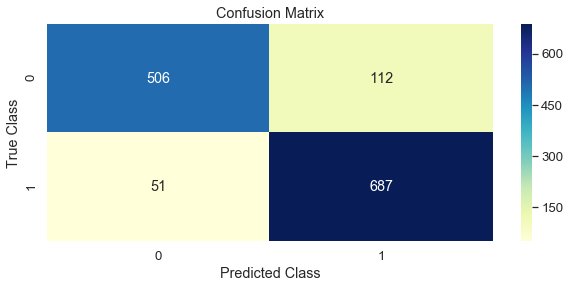

In [53]:
# get predictions
preds_tfdf = gs_tfdf.predict(X_test)
c_confusion_matrix(y_test, preds_tfdf)

 - The "1" which is Cricket category is predicted correctly => True positive score = 687
 - The "1" which is Cricket category is predicted incorrectly => False positive = 51
 - The "0" which is 'Soccer' category is predicted correctly => True negative = 506
 - The "0" which is 'Soccer' category is predicted incorrectly => False positive = 112

### ROC AUC Curve

Receiver Operating Characteristic (ROC) Curve  & Area under the ROC curve
 - I am using Receiver Operating Characteristic curve to visualize the overlap between my positive class and negative class by moving our classification threshold from 0 to 1.
 
 - I am using the **area under the ROC curve** (abbreviated **ROC AUC** or **AUC ROC**) to quantify the gap between our distributions.

In [54]:
pred_proba = [i[1] for i in gs_tfdf.predict_proba(X_test)]
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

In [55]:
from sklearn.metrics import roc_auc_score
roc_auc_score(pred_df['true_values'], pred_df['pred_probs'])

0.958179852834127

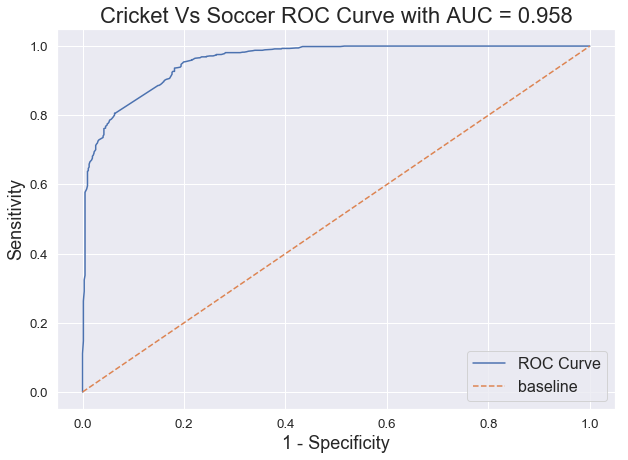

In [56]:
# Create figure.
plt.figure(figsize = (10,7))
# Create threshold values.
thresholds = np.linspace(0, 1, 200)
# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')
# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')
# Label axes.
plt.title(f'Cricket Vs Soccer ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)
# Create legend.
plt.legend(fontsize=16);

##### Interpreting ROC AUC

**We have an ROC AUC of close to 1.In otherwords in our Logistics Regression model our Cricket (positive) and Soccer (negative) populations are 95% perfectly separated. Looking at our model we can conclude that our model is very close to as good as it can get.**

### Model Coeficients

In [57]:
# Thanks to Varun for guidance:

In [58]:
##list the coeficients and concat into data frame
df_coef = pd.DataFrame(list(zip(results_gs_tfdf.best_estimator_.steps[0][1].get_feature_names(), 
                      results_gs_tfdf.best_estimator_.steps[1][1].coef_[0])), columns = ['word', 'coeficients'])

df_coef = df_coef.sort_values(by = 'coeficients', ascending = False)

In [59]:
##print first 10
df_cricket_coef = df_coef.head(10)

In [60]:
##print last 10
df_soccer_coef = df_coef.tail(10).sort_values('coeficients', ascending = False)

In [61]:
##concat
df_coef = pd.concat([df_cricket_coef, df_soccer_coef])

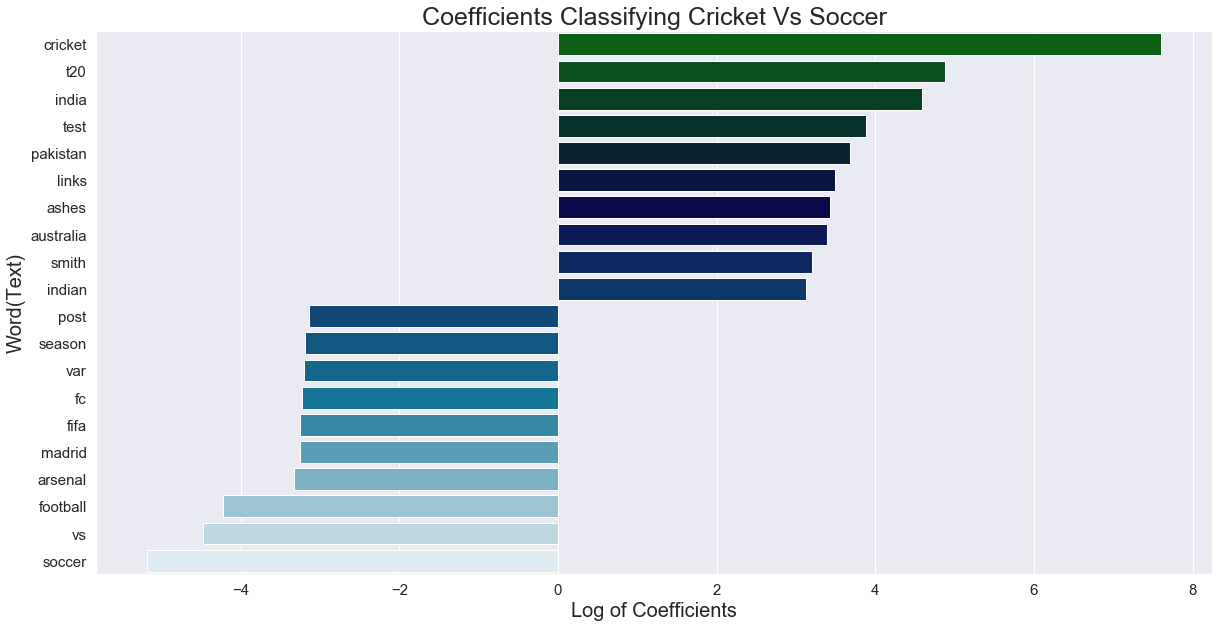

In [62]:
##plot coeficients
plt.figure(figsize=(20,10))
plt.title('Coefficients Classifying Cricket Vs Soccer',fontsize=25)
sns.set_style("darkgrid")
sns.barplot(data=df_coef ,x='coeficients',y='word',orient='h',palette='ocean')
plt.xlabel('Log of Coefficients',fontsize=20)
plt.ylabel('Word(Text)',fontsize=20)
plt.tick_params(labelsize=15)

Analysis of Coeficients
For a unit increase in the word 't20', the log-odds of the subreddit being 'Criket' increases by $\beta_1 = 6$ units. For a unit increase in the word 'Season', the log-odds of the subreddit being 'Cricket' decreases by $\beta_1 = 5 units.  

## Conclusion and Recommendations

**Conclusions :**
Using Pushshift's API we have successfully collected data from two of the subreddits viz. Cricket and Soccer. After doing the initial cleanup we have concatenated the dataframes to be used for training the model.
During the EDA we were able to find the most engaging posts, trend of the day wise engagement from Fans and most frequent words. We have also used the most frequent words to augment our stopwords list to test the possible improvement.

Using NLP we have trained our classifiers. We have calculated Base Line Score (Section 5.1), Logistic Regression Model score (Section 5.2 and 5.3), Gaussian NB Model (Section 5.4), Multinomial NB (Section 5.5) and Random Forest Model(Section 5.6) during our modeling process. We have used Count Vectorizer and TFIDF Vectorizer in our models.

We have evaluated the model using accuracy as the criteria. We have visually confirmed by plotting Confusion Matrix, ROC - AUC curve and Model Coefficients.

**All the models we have trained outperformed the Base Line model. TFIDF vector with Logistics Regression had the best Train and Test score. The scores were 0.92 on the Train Score and 0.88 on the Test score.**


**Recommendations :**

While our model trained on Logistic Regression with TFIDF vectorizer performed better than other models we still think there is a scope of improvement in the accuracy of the models. I noticed when I was analysing the various features comments column had usable iunformation (See graph below). I would like to do more feature Engineering to combine more data columns like 'Self Text'+ 'Title'+ 'Comments'. The present model is also slightly overfit. If we can get more data with different source other than Reddit we will be able to better train our classifiers. We will also like to train our models on other classifiers like Decision tree and Support Vector machines.

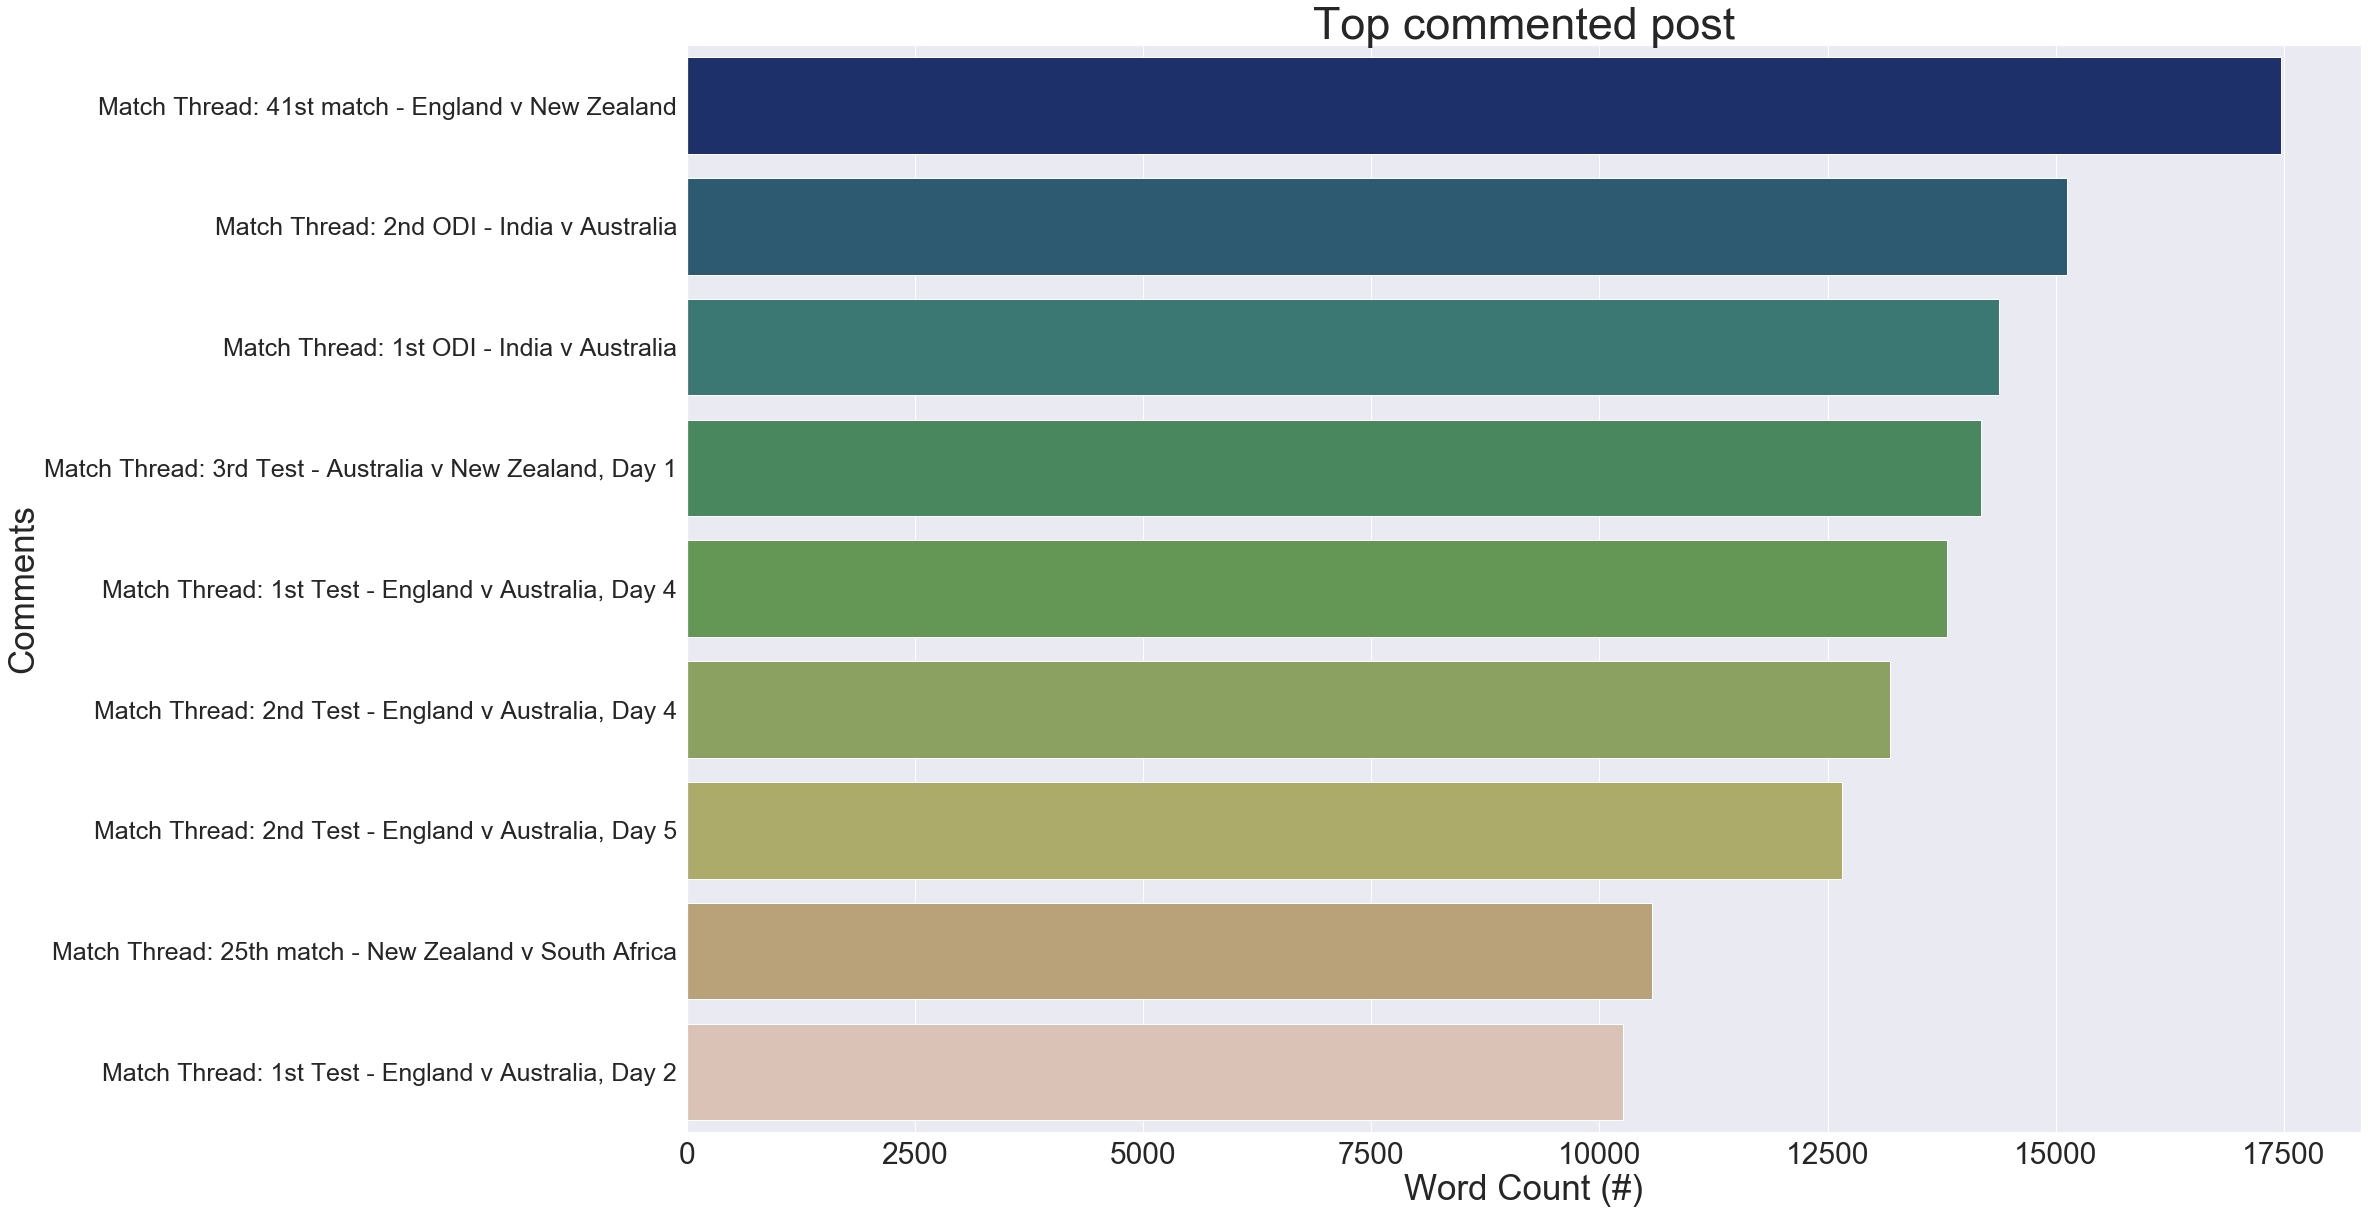

In [64]:
# visualizing the top commented posts.
plt.figure(figsize=(30,20))
plt.title ('Top commented post',
           size=45);
sns.barplot(data=df1_comments.sort_values('num_comments',ascending=False),
            y='title',
            x='num_comments',
            palette="gist_earth")
plt.ylabel('Comments', size = 35);
plt.xlabel('Word Count (#)', size = 35);
plt.yticks(size = 25);
plt.xticks(size = 30);